## Reading In Financial Data

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
%matplotlib inline 

In [2]:
data = pdr.get_data_yahoo('^GSPC',start = '1990-01-01', end = '2018-01-01')['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [3]:
data = pd.DataFrame(data)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7056 entries, 1990-01-02 to 2017-12-29
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  7056 non-null   float64
dtypes: float64(1)
memory usage: 110.2 KB


## Strategy Forum

In [5]:
data['SMA1'] = data['Adj Close'].rolling(50).mean()
data['SMA2'] = data['Adj Close'].rolling(100).mean()

In [6]:
data.tail()

,Adj Close,SMA1,SMA2
Date,,,
2017-12-22,2683.340088,2607.556411,2546.782319
2017-12-26,2680.500000,2610.103013,2548.865720
2017-12-27,2682.620117,2612.602617,2550.923621
2017-12-28,2687.540039,2615.166216,2552.989922
2017-12-29,2673.610107,2617.413218,2554.976824


In [7]:
from pylab import plt 
plt.style.use('ggplot')
%matplotlib inline

<AxesSubplot:xlabel='Date'>

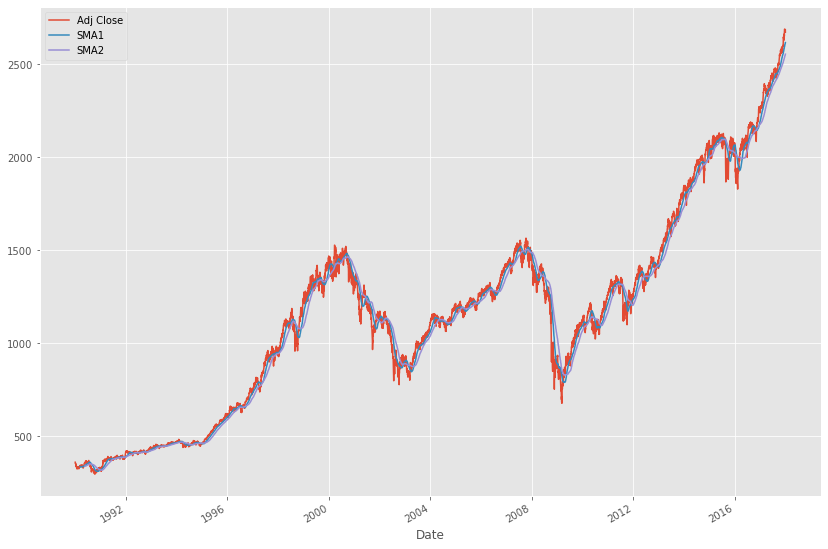

In [8]:
data.plot(figsize=(14,10))

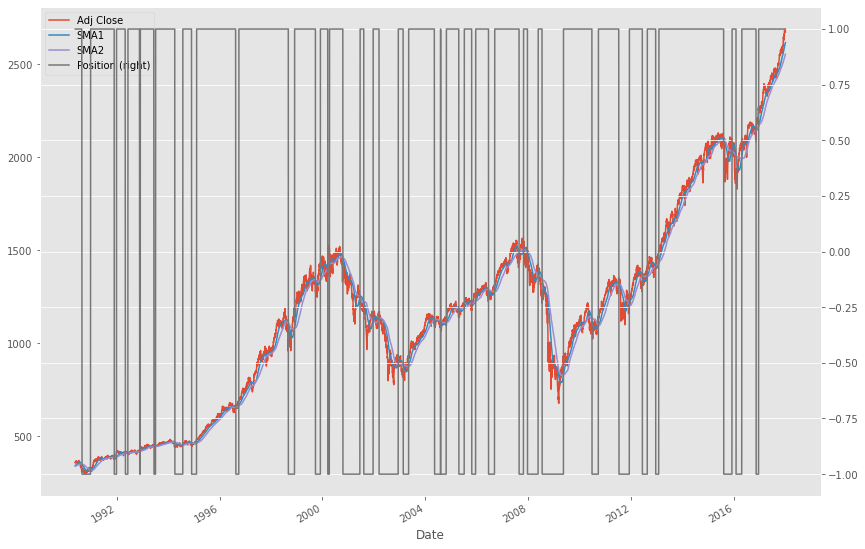

In [9]:
data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1 , -1)

data.dropna().plot(figsize =(14,10), secondary_y = 'Position');

## Log Returns 

In [10]:
data['Returns'] = np.log(data['Adj Close']/data['Adj Close'].shift(1))
data.head()

,Adj Close,SMA1,SMA2,Position,Returns
Date,,,,,
1990-01-02,359.690002,NaN,NaN,-1,NaN
1990-01-03,358.760010,NaN,NaN,-1,-0.002589
1990-01-04,355.670013,NaN,NaN,-1,-0.008650
1990-01-05,352.200012,NaN,NaN,-1,-0.009804
1990-01-08,353.790009,NaN,NaN,-1,0.004504


## Backtest 

In [11]:
data.dropna(inplace=True)
data['Strategy'] = data['Position'].shift(1)*data['Returns']
data.dropna(inplace = True)
data.head()

,Adj Close,SMA1,SMA2,Position,Returns,Strategy
Date,,,,,,
1990-05-24,358.410004,342.226601,338.762601,1,-0.002452,-0.002452
1990-05-25,354.579987,342.556801,338.720801,1,-0.010744,-0.010744
1990-05-29,360.649994,342.931600,338.770601,1,0.016974,0.016974
1990-05-30,360.859985,343.278200,338.857200,1,0.000582,0.000582
1990-05-31,361.230011,343.671400,338.931600,1,0.001025,0.001025


In [12]:
data['Creturns'] = data['Returns'].cumsum()
data['Cstrategy'] = data['Strategy'].cumsum()
data.head()

,Adj Close,SMA1,SMA2,Position,Returns,Strategy,Creturns,Cstrategy
Date,,,,,,,,
1990-05-24,358.410004,342.226601,338.762601,1,-0.002452,-0.002452,-0.002452,-0.002452
1990-05-25,354.579987,342.556801,338.720801,1,-0.010744,-0.010744,-0.013196,-0.013196
1990-05-29,360.649994,342.931600,338.770601,1,0.016974,0.016974,0.003778,0.003778
1990-05-30,360.859985,343.278200,338.857200,1,0.000582,0.000582,0.004360,0.004360
1990-05-31,361.230011,343.671400,338.931600,1,0.001025,0.001025,0.005385,0.005385


In [13]:
data[['Creturns','Cstrategy']].iloc[-1]

Creturns     2.007055
Cstrategy    1.286711
Name: 2017-12-29 00:00:00, dtype: float64

In [14]:
np.exp(data[['Creturns','Cstrategy']].iloc[-1])

Creturns     7.441371
Cstrategy    3.620859
Name: 2017-12-29 00:00:00, dtype: float64

<AxesSubplot:xlabel='Date'>

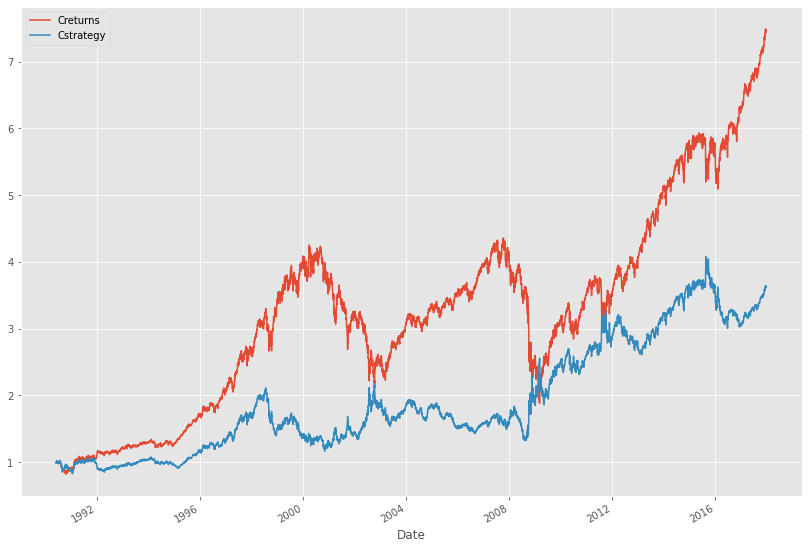

In [15]:
data[['Creturns','Cstrategy']].apply(np.exp).plot(figsize= (14,10))

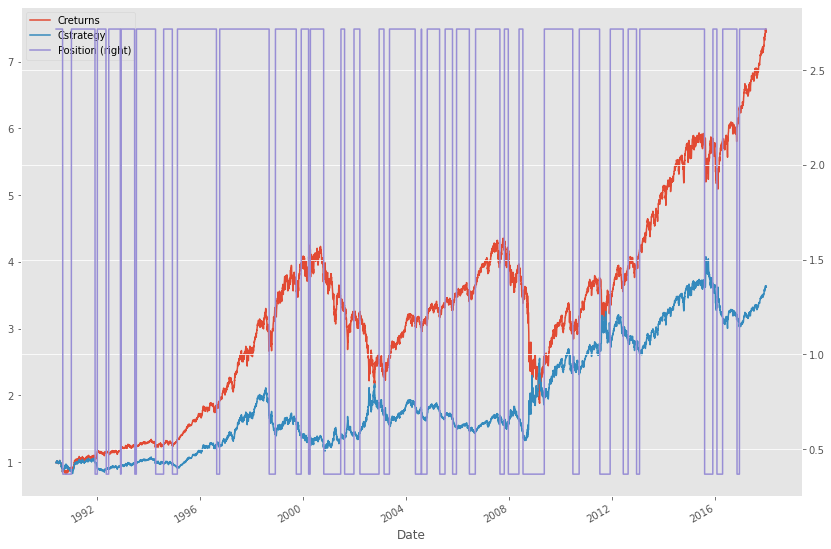

In [16]:
data[['Creturns', 'Cstrategy', 'Position']].apply(np.exp).plot(secondary_y='Position', figsize=(14,10));

## Optimization 

In [17]:
class Optimizer(object):
    def __init__(self, symbol, start, end,tc):
        self.symbol = symbol
        self.start = start
        self.end = end 
        self.tc = tc 
        self.get_data()
        
    def get_data(self):
        raw = pdr.get_data_yahoo(self.symbol, start = self.start, end = self.end)['Adj Close']
        raw = pd.DataFrame(raw)
        raw['Returns'] = np.log(raw['Adj Close'] / raw['Adj Close'].shift(1))
        self.data = raw.dropna()
         
    def plot_data(self, cols='Adj Close'):
        self.data[cols].plot(figsize=(14,10), title = self.symbol)
        
    def prepare_data(self):
        self.data['SMA1'] = self.data['Adj Close'].rolling(self.SMA1).mean()
        self.data['SMA2'] = self.data['Adj Close'].rolling(self.SMA2).mean()
        
    def run_strategy(self, SMA1, SMA2):
        self.SMA1 = SMA1
        self.SMA2 = SMA2
        self.prepare_data()
        data = self.data.dropna().copy()
        data['Position'] = np.where (data['SMA1'] > data['SMA2'], 1, -1)
        data['Strategy'] = data['Position'].shift(1) * data['Returns']
        data.dropna(inplace=True)
        trades = (data['Position'].diff().fillna(0) !=0)
        data['Strategy'] = np.where(trades, data['Strategy'] - self.tc, data['Strategy'])
        data['CReturns'] = data['Returns'].cumsum().apply(np.exp)
        data['CStrategy'] = data['Strategy'].cumsum().apply(np.exp)
        self.results = data
        return data[['CReturns', 'CStrategy' ]].iloc[-1]
    
    def plot_results(self):
        self.results[['CReturns','CStrategy']].plot(figsize = (14, 10))
        

## Optimizer Tester

In [18]:
Kraken = Optimizer(symbol='^GSPC', start='2008-01-01', end='2018-01-01', tc=0.0)

[*********************100%***********************]  1 of 1 completed


In [19]:
Kraken.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2008-01-02 to 2017-12-29
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2518 non-null   float64
 1   Returns    2518 non-null   float64
dtypes: float64(2)
memory usage: 59.0 KB


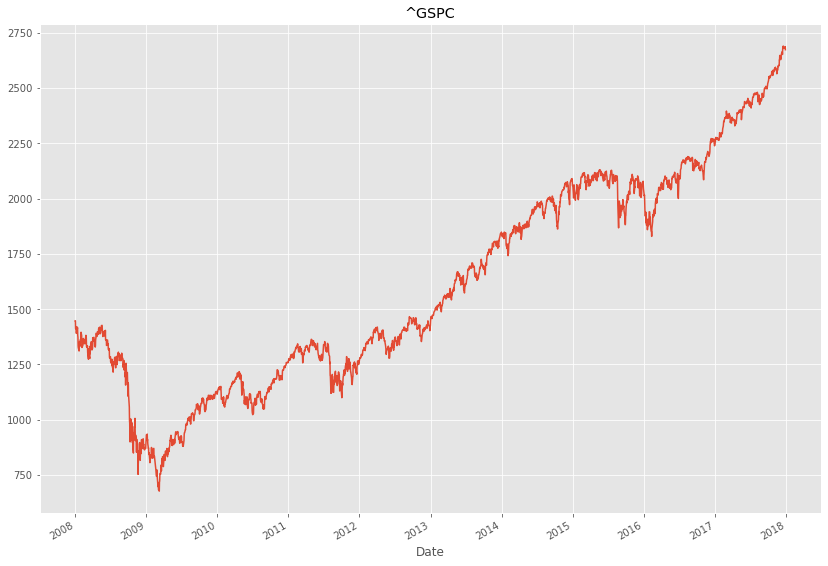

In [20]:
Kraken.plot_data()

In [21]:
Kraken.run_strategy(50,100)

CReturns     1.943129
CStrategy    2.245782
Name: 2017-12-29 00:00:00, dtype: float64

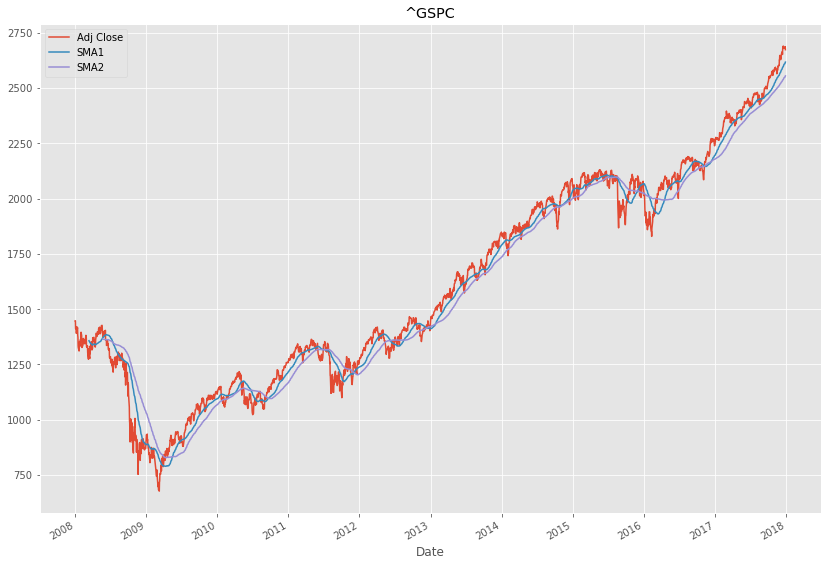

In [22]:
Kraken.plot_data(['Adj Close', 'SMA1', 'SMA2'])

In [23]:
list(zip([1,2,3],['a','b','c']))

[(1, 'a'), (2, 'b'), (3, 'c')]

In [24]:
import itertools as it

In [25]:
list(it.product([1,2,3],['a','b','c']))

[(1, 'a'),
 (1, 'b'),
 (1, 'c'),
 (2, 'a'),
 (2, 'b'),
 (2, 'c'),
 (3, 'a'),
 (3, 'b'),
 (3, 'c')]

In [26]:
list(it.product(range(10, 31, 5), range(50 , 101, 10)))[:6]

[(10, 50), (10, 60), (10, 70), (10, 80), (10, 90), (10, 100)]

## BFO

In [27]:
results = pd.DataFrame()
for SMA1, SMA2 in it.product(range(30,51,5),range(100, 150, 5)):
    res = Kraken.run_strategy(SMA1, SMA2)
    results = results.append(pd.DataFrame({'SMA1':SMA1, 'SMA2': SMA2,
                                          'CReturns' : res['CReturns'],
                                          'CStrategy' : res['CStrategy']},
                                            index=[0]),
                                            ignore_index=True)
results    

C:\Users\Kazem Kamrani\AppData\Local\Temp\ipykernel_10440\1657707932.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame({'SMA1':SMA1, 'SMA2': SMA2,
C:\Users\Kazem Kamrani\AppData\Local\Temp\ipykernel_10440\1657707932.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame({'SMA1':SMA1, 'SMA2': SMA2,
C:\Users\Kazem Kamrani\AppData\Local\Temp\ipykernel_10440\1657707932.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame({'SMA1':SMA1, 'SMA2': SMA2,
C:\Users\Kazem Kamrani\AppData\Local\Temp\ipykernel_10440\1657707932.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

C:\Users\Kazem Kamrani\AppData\Local\Temp\ipykernel_10440\1657707932.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame({'SMA1':SMA1, 'SMA2': SMA2,
C:\Users\Kazem Kamrani\AppData\Local\Temp\ipykernel_10440\1657707932.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame({'SMA1':SMA1, 'SMA2': SMA2,
C:\Users\Kazem Kamrani\AppData\Local\Temp\ipykernel_10440\1657707932.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame({'SMA1':SMA1, 'SMA2': SMA2,
C:\Users\Kazem Kamrani\AppData\Local\Temp\ipykernel_10440\1657707932.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

,SMA1,SMA2,CReturns,CStrategy
0,30,100,1.943129,1.635826
1,30,105,1.929471,1.728866
2,30,110,1.963349,1.873933
3,30,115,1.965687,2.072882
4,30,120,2.028536,2.600705
5,30,125,2.088758,2.454610
6,30,130,2.099089,2.235988
7,30,135,2.200665,2.189004
8,30,140,2.093665,2.349816
9,30,145,2.116538,2.153271
